## Import

In [1]:
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
from PIL import Image
import torch.nn.functional as F
import cv2
# from sklearn.model_selection import train_test_split

%matplotlib inline

## Root

In [2]:
ROOT_PATH = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03'

In [3]:
dataset_folder = 'dataset_C_v_2.9.3'

train_img_path = os.path.join(ROOT_PATH, dataset_folder, 'train_for_base_imgs')
train_mask_path = os.path.join(ROOT_PATH, dataset_folder, 'train_for_base_mask')

valid_img_path = os.path.join(ROOT_PATH, dataset_folder, 'valid_imgs')
valid_mask_path = os.path.join(ROOT_PATH, dataset_folder, 'valid_mask')

test_img_path = os.path.join(ROOT_PATH, dataset_folder, 'test_imgs')
test_mask_path = os.path.join(ROOT_PATH, dataset_folder, 'test_mask')

## Aug

In [4]:
img_size = 224
train_bsz = 4
device = 'cuda'
epochs = 30
valid_bsz = 8
test_bsz = 8

## Dataset

In [5]:
def get_df(img_path, mask_path):
    images, masks = [], []

    i = 0

    for get_img_name in os.listdir(img_path):
        images += [os.path.join(img_path, get_img_name)] # NORMAL_G1_Lid1_LRid293_Gid3133_Bl30.png
        masks += [os.path.join(mask_path, get_img_name.replace(get_img_name.split('_')[-1], 'C4.png'))] # NORMAL_G1_Lid1_LRid293_Gid3133_C4.png
        
        i = i+1

    PathDF = pd.DataFrame({'images': images, 'masks': masks})
    print(i)
    PathDF.head()
    return PathDF

In [6]:
train_df = get_df(train_img_path, train_mask_path)
valid_df = get_df(valid_img_path, valid_mask_path)
test_df = get_df(test_img_path, test_mask_path)

11313
1037
917


In [7]:
def plot_example(idx, df):
    image_path = df['images'].iloc[idx]
    mask_path = df['masks'].iloc[idx]
    image = Image.open(image_path)#.convert('RGB')
    mask = Image.open(mask_path)#.convert('RGB')
    
    fig, ax = plt.subplots(1, 3, figsize=(8,4))
    ax[0].imshow(np.array(image).astype(np.uint8))
    ax[0].set_title("Image")
    ax[1].imshow(np.array(mask).astype(np.uint8))
    ax[1].set_title("Mask")
    img = np.array(image) * 0.3 + np.array(mask) * 0.7
    img = img.astype(np.uint8)
    ax[2].imshow(img)
    ax[2].set_title('')
    plt.show()

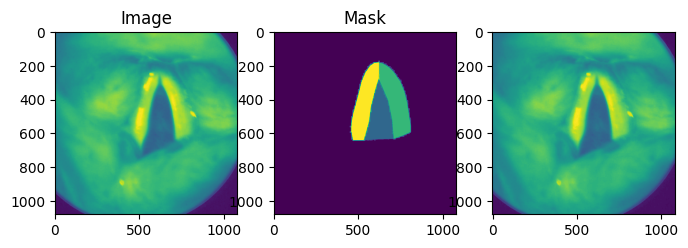

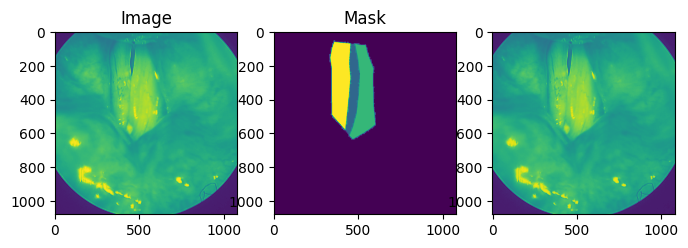

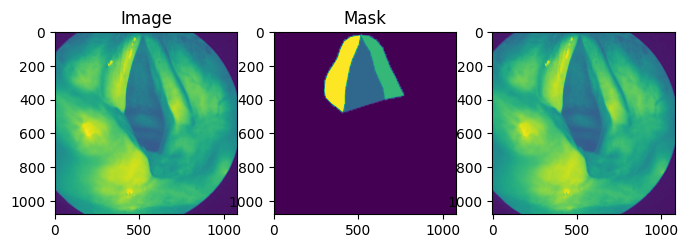

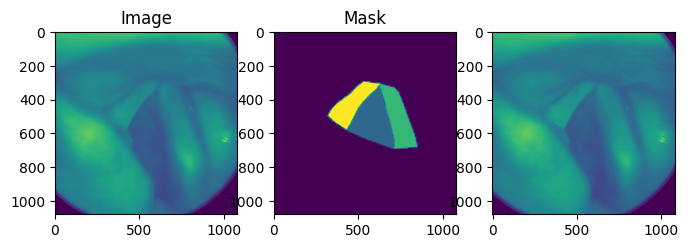

In [8]:
plot_example(0, train_df)
plot_example(50, valid_df)
plot_example(88, test_df)
plot_example(190, train_df)

In [9]:
transform = transforms.Compose([
            transforms.ToTensor()
            ])

In [10]:
# mask_path = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03/dataset_C_v_2.9.3/train_for_base_mask/RSLN_L_G10_Lid45_LRid112_Gid7024_C4.png'
# label = Image.open(mask_path)
# label = np.array(label)

In [11]:
class mod_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        if self.transform is not None:
            trans_Resize = transforms.Resize(224)

            images = trans_Resize(Image.open(self.path_df.iloc[idx]['images']).convert('RGB'))
            images = self.transform(images)

            mask = trans_Resize(Image.open(self.path_df.iloc[idx]['masks']))
            mask = np.array(mask)
            masks = np.zeros([np.max(np.unique(mask))+1, mask.shape[0], mask.shape[1]])
            for i in range(mask.shape[0]):
                for j in range(mask.shape[1]):
                    masks[mask[i][j]][i][j] = 1

            masks = torch.from_numpy(masks)
            masks = masks.type(torch.float32)

            # trans_toPIL = transforms.ToPILImage()
            
            # images = self.transform(trans_toPIL(cv2.imread(self.path_df.iloc[idx]['images'])))

            # mask = cv2.imread(self.path_df.iloc[idx]['masks'])
            # masks = np.zeros([mask.shape[0], mask.shape[1], np.max(np.unique(mask))])
            # for i in range(mask.shape[0]):
            #     for j in range(mask.shape[1]):
            #         masks[i][j][mask[i][j]] = 1

            # masks = self.transform(trans_toPIL(masks.astype(np.uint8)))

        return images, masks

In [12]:
train_data = mod_Dataset(train_df, transform)
valid_data = mod_Dataset(valid_df, transform)
test_data  = mod_Dataset(test_df, transform)

train_loader = DataLoader(train_data, batch_size=train_bsz, shuffle=True , num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=valid_bsz, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data , batch_size=test_bsz , shuffle=False, num_workers=0)

In [13]:
# image, mask = train_data[1]
# print(mask.shape, type(mask), mask.dtype, np.unique(np.asarray(mask)[0]))

In [14]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

torch.Size([4, 224, 224])


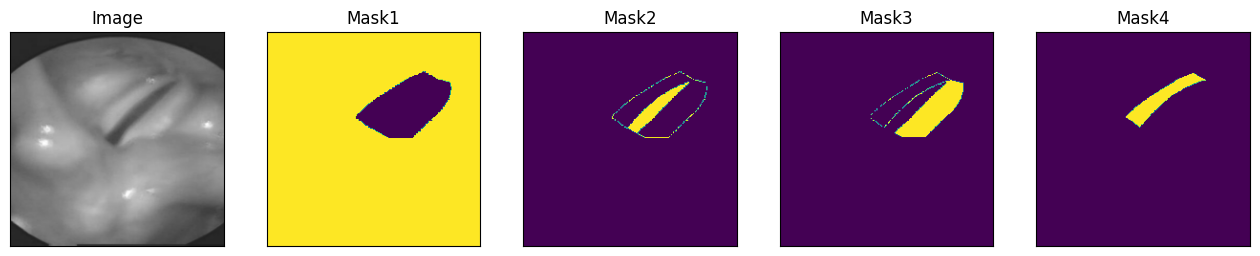

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [15]:
# Lets look at data we have
dataset = train_data

image, mask = dataset[1] # get some sample
#print(mask)
print(mask.shape)
mask = np.asarray(mask).transpose(1, 2, 0)
visualize(
    image=np.asarray(image).transpose(1, 2, 0),
    mask1=mask[..., 0],
    mask2=mask[..., 1],
    mask3=mask[..., 2],
    mask4=mask[..., 3],
)
for i in range(4):
    print(np.unique(mask[..., i]))

In [16]:
for x, y in train_loader:
    # print(x.shape)
    print(y.shape)
    break

torch.Size([4, 4, 224, 224])


## Model

In [17]:
class Decoder(nn.Module):
  def __init__(self, in_channels, middle_channels, out_channels):
    super(Decoder, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv_relu = nn.Sequential(
        nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
        )
  def forward(self, x1, x2):
    x1 = self.up(x1)
    x1 = torch.cat((x1, x2), dim=1)
    x1 = self.conv_relu(x1)
    return x1

class Unet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(weights='DEFAULT')
        self.base_layers = list(self.base_model.children())
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            self.base_layers[1],
            self.base_layers[2])
        self.layer2 = nn.Sequential(*self.base_layers[3:5])
        self.layer3 = self.base_layers[5]
        self.layer4 = self.base_layers[6]
        self.layer5 = self.base_layers[7]
        self.decode4 = Decoder(512, 256+256, 256)
        self.decode3 = Decoder(256, 256+128, 256)
        self.decode2 = Decoder(256, 128+64, 128)
        self.decode1 = Decoder(128, 64+64, 64)
        self.decode0 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
            )
        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        e1 = self.layer1(input) # 64,128,128
        e2 = self.layer2(e1) # 64,64,64
        e3 = self.layer3(e2) # 128,32,32
        e4 = self.layer4(e3) # 256,16,16
        f = self.layer5(e4) # 512,8,8
        d4 = self.decode4(f, e4) # 256,16,16
        d3 = self.decode3(d4, e3) # 256,32,32
        d2 = self.decode2(d3, e2) # 128,64,64
        d1 = self.decode1(d2, e1) # 64,128,128
        d0 = self.decode0(d1) # 64,256,256
        out = self.conv_last(d0) # 1,256,256
        return out

In [18]:
import segmentation_models_pytorch as smp

In [19]:
model = smp.Unet(
    in_channels=3,                  
    classes=4,
    activation="softmax").to(device)

In [20]:
# model = Unet(4).to(device)
# # print(model)
t = torch.randn((4, 3, 224, 224)).to(device)
print(t.shape)
get = model(t)
print(get.shape)

# for x, y in train_loader:
#     print(x.shape)
#     print(y.shape)
#     break

torch.Size([4, 3, 224, 224])
torch.Size([4, 4, 224, 224])


/home/yasaisen/.local/lib/python3.8/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


## Train

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction:
            return torch.mean(F_loss)
        else:
            return F_loss

In [22]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

In [23]:
def train_loop(model, optimizer, criterion, train_loader, device=device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')

    final_dice_coef = 0 
    
    for imgs, masks in pbar:
        # pass to device

        # print(type(imgs), imgs.shape)
        # print(type(masks), masks.shape)

        imgs = imgs.to(device)
        masks = masks.to(device)

        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
#         print(loss.item())
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

In [24]:
def eval_loop(model, criterion, eval_loader, device=device):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        pbar = tqdm(eval_loader, desc='Interating over evaluation data')
        
        for imgs, masks in pbar:
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
#             print(loss.item())
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

In [25]:
def train(model, optimizer, criterion, scheduler, train_loader, 
          valid_loader,device = device,
          num_epochs = epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, train_loader, device=device)
        
        val_metrics = eval_loop(model, criterion, valid_loader, device=device)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        if val_metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), "UNET.pt")
            valid_loss_min = val_metrics["loss"]
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
# criterion = nn.BCELoss(reduction='mean')
criterion = FocalLoss()
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader)

Interating over evaluation data: 100%|██████████| 130/130 [00:43<00:00,  3.02it/s]


Epoch: 1
Train Loss: 0.01999
Train Dice Coef: 0.94903
Valid Loss: 0.07633
Valid Dice Coef: 0.86004



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.11it/s]


Epoch: 2
Train Loss: 0.01061
Train Dice Coef: 0.97119
Valid Loss: 0.03958
Valid Dice Coef: 0.92159



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.05it/s]


Epoch: 3
Train Loss: 0.00849
Train Dice Coef: 0.97690
Valid Loss: 0.05353
Valid Dice Coef: 0.91254



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.07it/s]


Epoch: 4
Train Loss: 0.00753
Train Dice Coef: 0.97949
Valid Loss: 0.05166
Valid Dice Coef: 0.91599



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.13it/s]


Epoch: 5
Train Loss: 0.46713
Train Dice Coef: 0.95073
Valid Loss: 3.29754
Valid Dice Coef: 0.79596



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.07it/s]


Epoch: 6
Train Loss: 1.88491
Train Dice Coef: 0.87952
Valid Loss: 3.22809
Valid Dice Coef: 0.82029



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.09it/s]


Epoch: 7
Train Loss: 1.85153
Train Dice Coef: 0.89499
Valid Loss: 3.22478
Valid Dice Coef: 0.82193



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.14it/s]


Epoch: 8
Train Loss: 1.84812
Train Dice Coef: 0.89570
Valid Loss: 3.22278
Valid Dice Coef: 0.82301



Interating over evaluation data: 100%|██████████| 130/130 [00:43<00:00,  3.01it/s]


Epoch: 9
Train Loss: 1.84229
Train Dice Coef: 0.89929
Valid Loss: 3.21645
Valid Dice Coef: 0.83229



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.07it/s]


Epoch: 10
Train Loss: 1.83637
Train Dice Coef: 0.90460
Valid Loss: 3.20623
Valid Dice Coef: 0.83861



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.07it/s]


Epoch: 11
Train Loss: 1.82814
Train Dice Coef: 0.90700
Valid Loss: 3.20249
Valid Dice Coef: 0.84038



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.11it/s]


Epoch: 12
Train Loss: 1.81797
Train Dice Coef: 0.90789
Valid Loss: 3.19059
Valid Dice Coef: 0.84113



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.04it/s]


Epoch: 13
Train Loss: 1.79901
Train Dice Coef: 0.90925
Valid Loss: 3.17871
Valid Dice Coef: 0.84239



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.09it/s]


Epoch: 14
Train Loss: 1.79183
Train Dice Coef: 0.91023
Valid Loss: 3.17928
Valid Dice Coef: 0.84321



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.14it/s]


Epoch: 15
Train Loss: 1.79739
Train Dice Coef: 0.91069
Valid Loss: 3.18284
Valid Dice Coef: 0.84326



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.09it/s]


Epoch: 16
Train Loss: 1.79639
Train Dice Coef: 0.91079
Valid Loss: 3.18190
Valid Dice Coef: 0.84329



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.13it/s]


Epoch: 17
Train Loss: 1.79646
Train Dice Coef: 0.91086
Valid Loss: 3.18296
Valid Dice Coef: 0.84368



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.11it/s]


Epoch: 18
Train Loss: 1.79725
Train Dice Coef: 0.91087
Valid Loss: 3.17810
Valid Dice Coef: 0.84483



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.08it/s]


Epoch: 19
Train Loss: 1.79717
Train Dice Coef: 0.91094
Valid Loss: 3.17544
Valid Dice Coef: 0.84452



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.08it/s]


Epoch: 20
Train Loss: 1.79741
Train Dice Coef: 0.91094
Valid Loss: 3.17943
Valid Dice Coef: 0.84410



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.07it/s]


Epoch: 21
Train Loss: 1.79696
Train Dice Coef: 0.91101
Valid Loss: 3.18035
Valid Dice Coef: 0.84394



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.11it/s]


Epoch: 22
Train Loss: 1.79734
Train Dice Coef: 0.91093
Valid Loss: 3.18201
Valid Dice Coef: 0.84343



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.06it/s]


Epoch: 23
Train Loss: 1.79730
Train Dice Coef: 0.91103
Valid Loss: 3.18089
Valid Dice Coef: 0.84437



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.09it/s]


Epoch: 24
Train Loss: 1.79747
Train Dice Coef: 0.91090
Valid Loss: 3.18356
Valid Dice Coef: 0.84362



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.11it/s]


Epoch: 25
Train Loss: 1.79711
Train Dice Coef: 0.91092
Valid Loss: 3.17972
Valid Dice Coef: 0.84421



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.10it/s]


Epoch: 26
Train Loss: 1.79692
Train Dice Coef: 0.91098
Valid Loss: 3.17946
Valid Dice Coef: 0.84437



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.08it/s]


Epoch: 27
Train Loss: 1.79725
Train Dice Coef: 0.91085
Valid Loss: 3.18519
Valid Dice Coef: 0.84363



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.12it/s]


Epoch: 28
Train Loss: 1.79751
Train Dice Coef: 0.91092
Valid Loss: 3.18515
Valid Dice Coef: 0.84297



Interating over evaluation data: 100%|██████████| 130/130 [00:41<00:00,  3.11it/s]


Epoch: 29
Train Loss: 1.79736
Train Dice Coef: 0.91093
Valid Loss: 3.18529
Valid Dice Coef: 0.84382



Interating over evaluation data: 100%|██████████| 130/130 [00:42<00:00,  3.06it/s]

Epoch: 30
Train Loss: 1.79707
Train Dice Coef: 0.91090
Valid Loss: 3.18071
Valid Dice Coef: 0.84373



In [33]:
torch.save(model, "UNET_2305150829.pt")

In [ ]:
model = 

In [32]:
# Lets look at data we have
dataset = train_data

image, mask = dataset[1] # get some sample
mask = model(image.cuda())
#print(mask)
print(mask.shape)
mask = np.asarray(mask).transpose(1, 2, 0)
visualize(
    image=np.asarray(image).transpose(1, 2, 0),
    mask1=mask[..., 0],
    mask2=mask[..., 1],
    mask3=mask[..., 2],
    mask4=mask[..., 3],
)
for i in range(4):
    print(np.unique(mask[..., i]))

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

## Eval

In [27]:
def plot_predictions(model, idx, transforms):
    img = Image.open(test_df['images'].iloc[idx]).convert('RGB')
    mask = Image.open(test_df['masks'].iloc[idx])
    
    tensor_img = transforms(img)
    tensor_img = tensor_img.unsqueeze(0).to(device)
    
    model.eval()
    
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1,2,0)).squeeze()
        print(np.max(pred))
        rounded = np.round(pred)

    
        
    plot_images = {
        'Image': img,
        'Mask': mask,
        'Predicted Mask': pred,
        'Predicted Rounded Mask':rounded
    }
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
        
    plt.show()

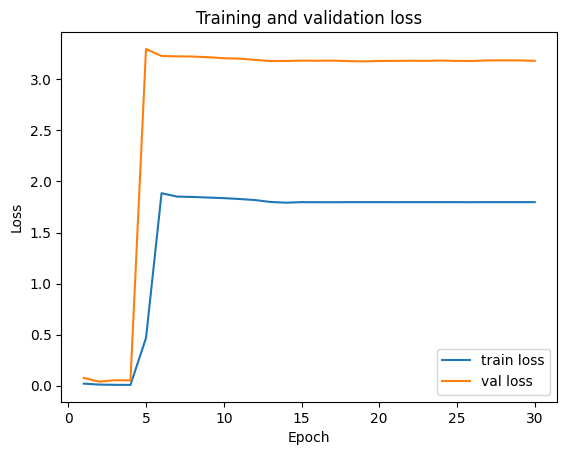

In [28]:
plt.plot(np.arange(1, epochs + 1), train_loss_list, label="train loss")
plt.plot(np.arange(1, epochs + 1), val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

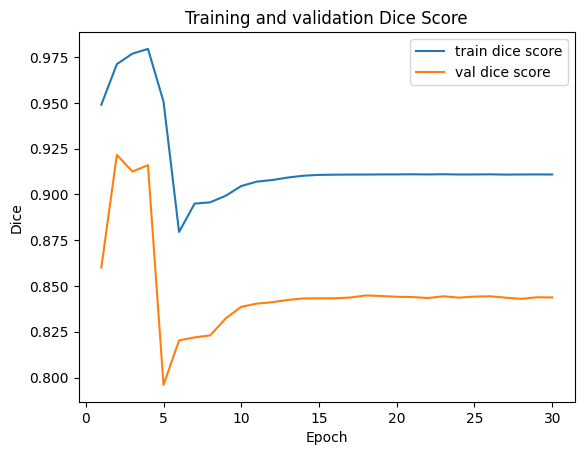

In [29]:
plt.plot(np.arange(1, epochs + 1), train_dice_coef, label="train dice score")
plt.plot(np.arange(1, epochs + 1), val_dice_coef, label="val dice score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.title("Training and validation Dice Score")
plt.show()

In [30]:
plot_predictions(model, 59, transform)
plot_predictions(model, 0, transform)
plot_predictions(model, 26, transform)
plot_predictions(model, 3, transform)

RuntimeError: Wrong input shape height=1080, width=1080. Expected image height and width divisible by 32. Consider pad your images to shape (1088, 1088).